In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
import plotly.graph_objects as go

%matplotlib inline

### gets rid of the Matplotlib Deprecation Warning from the Graph
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pd.set_option('display.max_colwidth', -1)
pd.set_option("display.max_rows",1500)

In [2]:
movie_df = pd.read_json('cleaned_godfather.json').rename(columns = {0:'Role', 1: 'Line'})

In [3]:
movie_df['Word Count'] = [len(x.split()) for x in movie_df['Line']]

In [4]:
word_count_df = movie_df.groupby(['Role'])['Word Count'].sum().reset_index(name = 'Word Count')

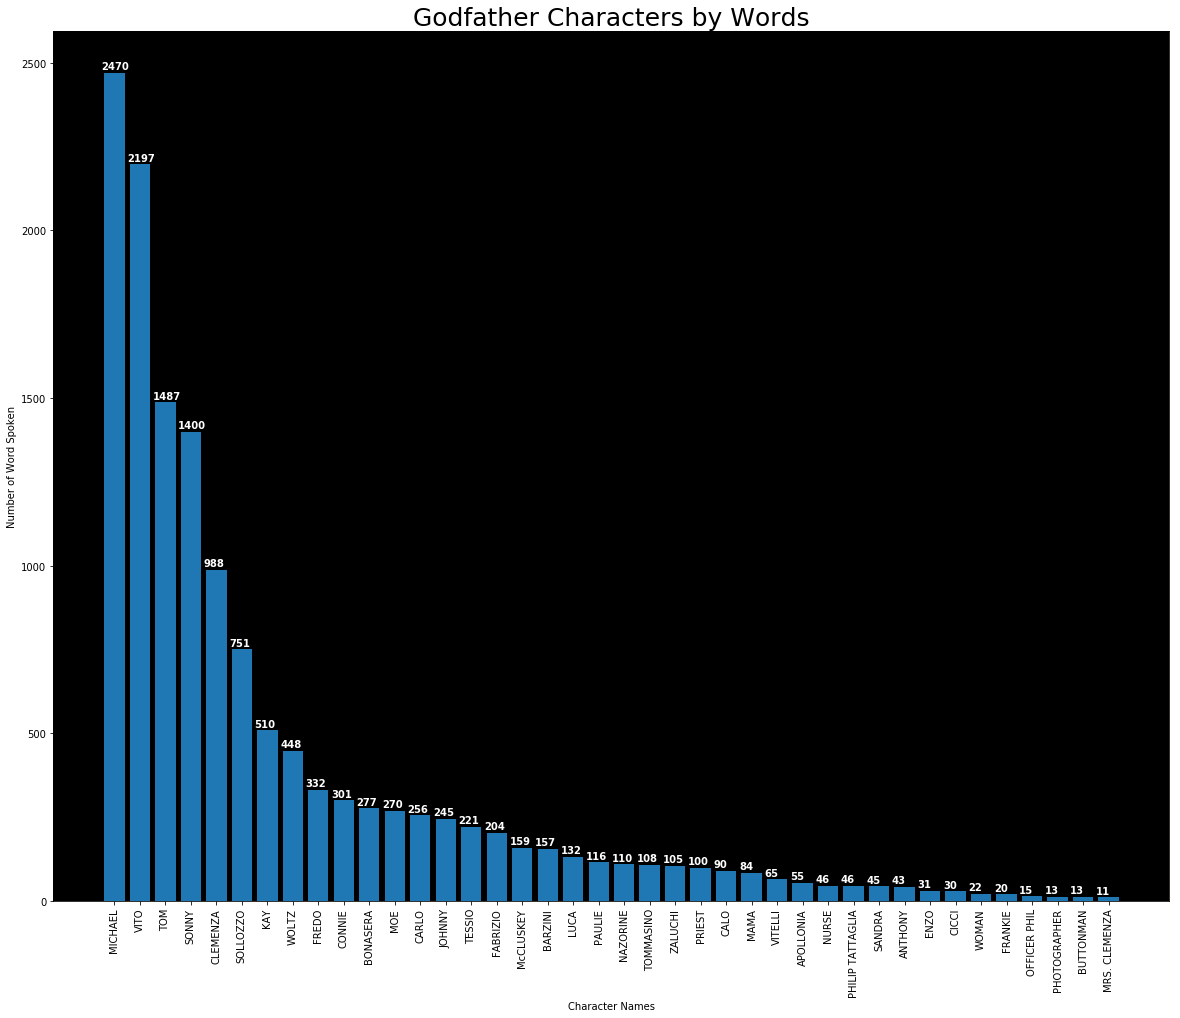

In [5]:
remove_lst = ['CUT TO:', 'DISSOLVE TO:', 'FADE FROM BLACK:', 'OVERLAY:', 'PAN:',
       'THE END', 'VOICE', 'VOICE ON THE PHONE']

removed = word_count_df[~word_count_df.Role.isin(remove_lst)]
filtered = removed.loc[word_count_df['Word Count']>10]

fig, ax = plt.subplots(1,1,figsize =(20,16))
sorted_df = filtered.sort_values('Word Count', ascending=False)#.plot('Role', 'Word Count', kind = 'bar')
plt.xticks(rotation=90)
plt.bar('Role', 'Word Count', data=sorted_df)
plt.xlabel('Character Names')
plt.ylabel('Number of Word Spoken')
plt.title('Godfather Characters by Words', size = 25)
ax.set_facecolor('black')

for i, v in enumerate(sorted_df['Word Count']):
    plt.text(i-.5, v+10, str(v), color='white', fontweight='bold')

In [6]:
scenes_lst= []
index = 0
while index< len(movie_df):
    person = movie_df.iloc[index,0]
    
    scene = []
    while (':' not in person) and index< len(movie_df)-1:
        scene.append(person)
        index+=1
        person = movie_df.iloc[index,0]

    if (scene !=[]) and len(scene)!=1:
        scenes_lst.append(scene)
    index+=1

In [7]:
conversations_been_part_of = dict()
for i in scenes_lst:
    for j in pd.Series(i).value_counts().index:
        try:
            conversations_been_part_of[j]+=1
        except KeyError:
            conversations_been_part_of[j]= 1

In [8]:
scene_lim = 1
in_order = sorted([list(tuple(conversations_been_part_of.items())[x])
                   for x in range(len(conversations_been_part_of))], key=lambda value: value[1], reverse=True)

over_scene_lim = np.array([x for x in in_order if (x[1]>scene_lim) and x[0] not in remove_lst])
over_scene_lim_df = pd.DataFrame({'Role':over_scene_lim[:,0],'Scene':over_scene_lim[:,1].astype(int) })

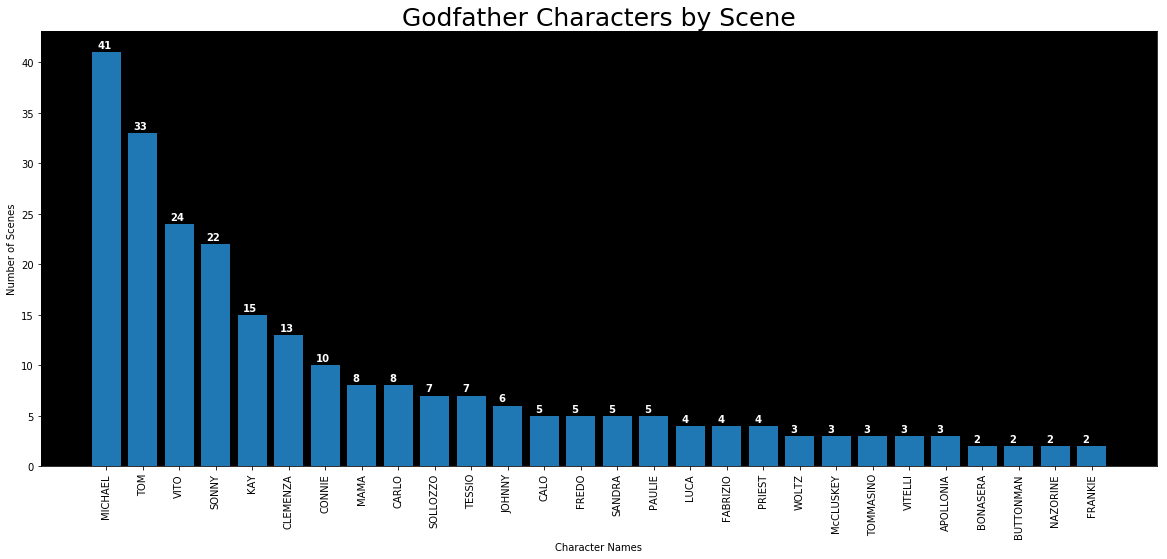

In [9]:
fig, ax = plt.subplots(1,1,figsize =(20,8))
sorted_df = over_scene_lim_df.sort_values('Scene', ascending=False)#.plot('Role', 'Scene', kind = 'bar')
plt.xticks(rotation=90)
plt.bar('Role', 'Scene', data= sorted_df)
plt.xlabel('Character Names')
plt.ylabel('Number of Scenes')
plt.title('Godfather Characters by Scene', size = 25)
ax.set_facecolor('black')

for i, v in enumerate(sorted_df['Scene']):
    plt.text(i-.25, v+.4, str(v), color='white', fontweight='bold')

In [10]:
edge_dict = {}
for scene in scenes_lst:
    unique = pd.Series(scene).unique()
    for i in range(len(unique)):
        for j in range(i+1, len(unique)):
            if any(x not in over_scene_lim for x in [unique[i], unique[j]]): 
                continue
            combo = unique[i]+'-'+unique[j] if unique[i] < unique[j] else unique[j]+'-'+unique[i]
            try:
                edge_dict[combo]+=len([x for x in scene if x==unique[i]])
            except KeyError:
                edge_dict[combo]=len([x for x in scene if x==unique[i]])

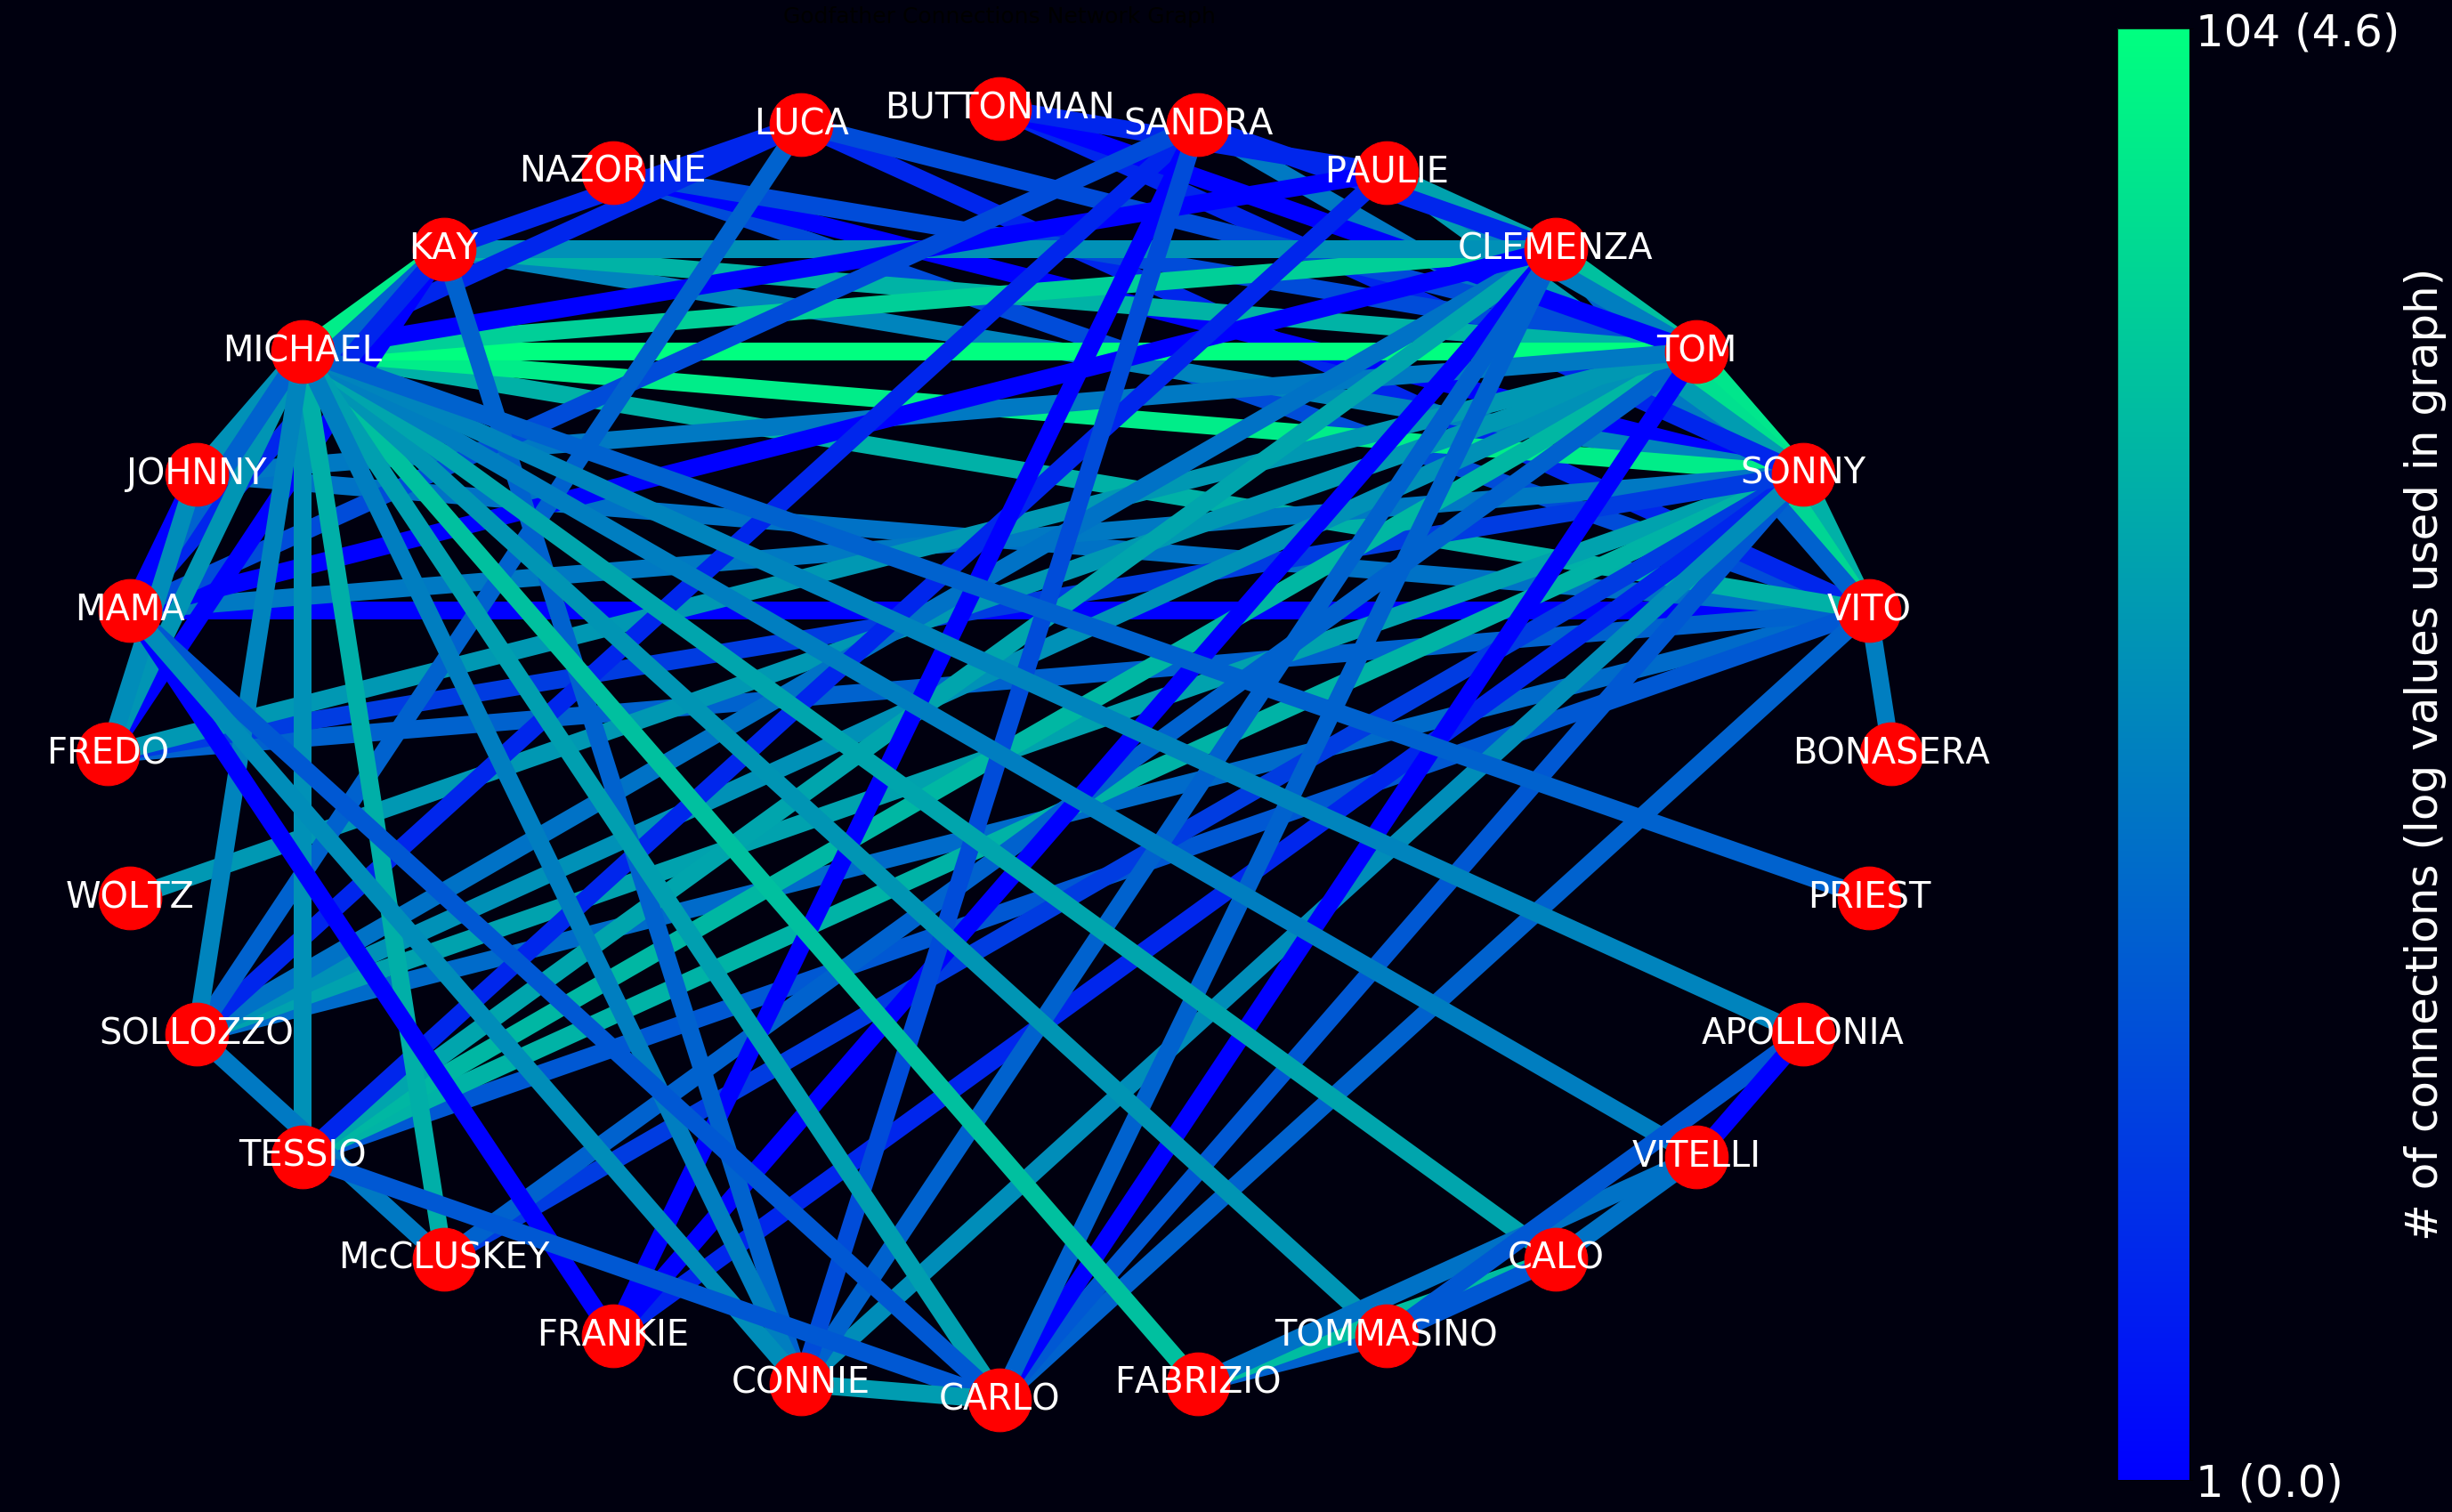

In [11]:
Network = nx.Graph()
fig, ax = plt.subplots(1,1, figsize=(50,30))

color='white'
cmap=plt.cm.winter

for i in edge_dict.keys():
    split = i.split('-')
    Network.add_edge(split[0],split[1], weight=edge_dict[i])

### since edges changes the order of edges from the way they are added
#logged values to see more subtule relationships
weights = [np.log(x[2]) for x in list(Network.edges(data='weight'))]

vmin = min(edge_dict.values())
vmax = max(edge_dict.values())

nx.draw_circular(Network, with_labels=True, width= 20, ax=ax, font_size = 40, node_size = 5000, node_color='red',
                 edge_cmap = cmap, edge_color = weights,edge_vmin=min(weights), edge_vmax= max(weights),font_color=color)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []

cbar = plt.colorbar(sm, ticks = [vmin,vmax])
cbar.ax.set_yticklabels([str(vmin)+f' ({round(min(weights),1)})',str(vmax)+f' ({round(max(weights),1)})'], color='white')
cbar.ax.tick_params(labelsize=50)
cbar.set_label('# of connections (log values used in graph)', size = 50, color = 'white')

fig.set_facecolor("#00000F")
plt.title('Networkx',size = 100)
plt.title('Godfather Connections Network Graph', size = 25)
plt.show()

In [12]:
G = nx.random_geometric_graph(Network.node, 0, seed=40)

In [13]:
for x,y in edge_dict.items():
    G.add_edge(x[:x.find('-')],x[x.find('-')+1:],weight=y)

In [14]:
middle_x=[]
middle_y=[]
middle_text=[]

edge_x = []
edge_y = []
for start,end,data in G.edges(data=True):
    x0, y0 = G.node[start]['pos']
    x1, y1 = G.node[end]['pos']
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None] 
    
    middle_x.append((x0+x1)/2)
    middle_y.append((y0+y1)/2)
    middle_text.append(str(data['weight'])+ f' connections between {start} and {end}')
    
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#646efa'),
    mode='lines',
    )

In [15]:
node_x = []
node_y = []
for node in G.nodes():
    x, y = G.node[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x+middle_x, y=node_y+middle_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=False,
        color=[],
        size=[],
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_color = 'black',
        opacity =[],
        line_width=2))

In [16]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    connections = [x['weight'] for x in list(adjacencies[1].values())]
    node_adjacencies.append(sum(connections))
    node_text.append(f'{adjacencies[0]}. Connections: {sum(connections)} with {len(connections)} people')

node_trace.marker.color = node_adjacencies
node_trace.text = node_text+ middle_text
node_trace.marker.size = [10]*len(node_x) + [5]*len(middle_x)
node_trace.marker.opacity = [1]*len(node_x) + [0.05]*len(middle_x)

In [17]:
fig = go.Figure(data=[edge_trace,node_trace],
             layout=go.Layout(
                title='Godfather Network',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="github.com/Shonak98/Godfather-Fun",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()